In [1]:
from comet_ml import Experiment
from pytorch_lightning.loggers import CometLogger
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import numpy as np
from argparse import ArgumentParser, Namespace

from utils import *
from models import *
from dataset import *
from lightning_model import EffectsNet

pl.seed_everything(0)

Global seed set to 0


0

In [2]:
from models import *
from dataset import *
from lightning_model import *
from utils import *

In [3]:
hparams = {
    'architecture': 'damskagg', # damskagg or tcn,
    'loss_functions': ['esr'],
    'specific_fx_name':'overdrive',
    'comments': 'notebook investigation',
    'num_channels':12,
    'dilation_depth':10,
    'dilation_factor': 2,
    'num_repeat': 1,
    'kernel_size': 3,
    'conditioning': False,
    'num_conditioning': 3,
    'fx_list': None,
    'activation':'prelu',
    'grouping':'local',
    'batch_size': 1,
    'learning_rate':3e-3,
    'gpus':-1,
    'tpu_cores':None,
    'cpu':False,
    'resume':False,
    'sample_duration': 10,
    'train_x_path':'/home/jovyan/simple-overdrive/train_x', 
    'train_y_path':'/home/jovyan/simple-overdrive/train_y', 
    'val_x_path':'/home/jovyan/simple-overdrive/val_x', 
    'val_y_path':'/home/jovyan/simple-overdrive/val_y',
    'impulse_x_path':'/home/jovyan/simple-overdrive/impulse_x', 
    'impulse_y_path':'/home/jovyan/simple-overdrive/impulse_y',
    'sample_rate': 44100
    }
rf = compute_receptive_field(kernel_pattern=[hparams['kernel_size']]*hparams['dilation_depth'], 
                             dilation_pattern=[hparams['dilation_factor'] ** i for i in range(hparams['dilation_depth'])]*hparams['num_repeat'])
rf_s =  np.round(rf/hparams['sample_rate'], 2)
hparams['rf'] = rf
hparams['rf_s'] = rf_s
print(f"Receptive field: {rf} samples or {rf_s} s")
args = Namespace(**hparams)

Receptive field: 2047 samples or 0.05 s


In [4]:
model = EffectsNet(hparams)

Using Damskagg model


In [5]:
if args.specific_fx_name:
    name = f'{args.specific_fx_name}-{args.architecture}-{args.rf_s}rf-{str(args.conditioning)}Cond'
else:
    name = f'{args.fx_list}-{args.architecture}-{args.rf_s}rf'

comet_logger = CometLogger(
    api_key='FYtBowp9xX2d6bW4xpVDedmw7',
    workspace='vincnt',  # Optional
    project_name="audio-fx",  # Optional
    experiment_name=name,  # Optional
    save_dir="comet_logs/"
)

early_stop_callback = EarlyStopping(monitor="combined_val/dataloader_idx_0", patience=20, verbose=False, check_finite=True)
checkpoint_callback = CheckpointSaverCallback(monitor="combined_val/dataloader_idx_0", every_n_epochs=1, save_top_k=1, auto_insert_metric_name=True)

trainer = pl.Trainer(
    gpus=None if args.cpu else args.gpus,
    tpu_cores=args.tpu_cores,
    log_every_n_steps=10,
    logger= comet_logger,
    callbacks=[checkpoint_callback, early_stop_callback],
    precision=32,
    max_time="00:01:00:00", # 1 hours
    progress_bar_refresh_rate=25
)

trainer.fit(model)

CometLogger will be initialized in online mode
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/vincnt/audio-fx/c8f7034a76684c86a112a0857877c2b5


  | Name        | Type            | Params
------------------------------------------------
0 | net         | DamskaggWaveNet | 10.6 K
1 | preemphasis | FIRFilter       | 101   
------------------------------------------------
10.6 K    Trainable params
101       Non-trainable params
10.7 K    Total params
0.043     Total estimated model params size (MB)


Global seed set to 0


/home/jovyan/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/callback_hook.py:102: LightningDeprecationWarning: The signature of `Callback.on_train_epoch_end` has changed in v1.3. `outputs` parameter has been removed. Support for the old signature will be removed in v1.5
  warning_cache.deprecation(
/home/jovyan/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1047: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
COMET ERROR: Experiment.log_model() requires a file or folder
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/vincnt/audio-fx/c8f7034a76684c86a112a0857877c2b5
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     combined_val/dataloader_idx_0 : 

CheckpointSaverCallback - Keyboard Interrupt. Best model path, best model score comet_logs/audio-fx/c8f7034a76684c86a112a0857877c2b5/checkpoints/epoch=0-step=18.ckpt tensor(3187.7473, device='cuda:0')


COMET INFO: Uploading metrics, params, and assets to Comet before program termination (may take several seconds)
COMET INFO: The Python SDK has 3600 seconds to finish before aborting...


In [9]:
model.train_ds[0]

(array([[ 0.        ,  0.        ,  0.        , ..., -0.22437893,
         -0.24021852, -0.24949643]], dtype=float32),
 array([[ 11264.,  11207.,  11151., ..., -21631., -21801., -21864.]],
       dtype=float32),
 array([[0.2, 1. , 0. ]], dtype=float32),
 {'name': '105_F_TillTheMo.wav',
  'fx': 'overdrive',
  'p1': 0.2,
  'p2': 1.0,
  'p3': 0.0})

In [10]:
import IPython.display as ipd

In [11]:
ipd.Audio(model.train_ds[0][0], rate=44100)

In [15]:
model.train_ds[0][0].squeeze().mean()

-1.0807658e-05

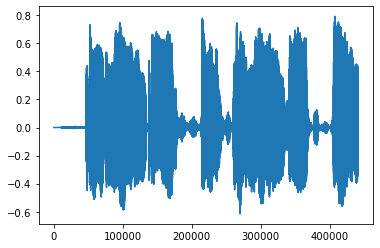

In [14]:
import matplotlib.pyplot as plt
plt.plot(model.train_ds[0][0].squeeze())